<a href="https://colab.research.google.com/github/IagoMagalhaes23/SAM_DinoV2/blob/main/YOLO_NAS%2BSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalações

In [1]:
!pip install super-gradients==3.1.0
!pip install imutils
!pip install pytube --upgrade
!pip install pycocotools matplotlib onnxruntime onnx
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ha0n8qg9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ha0n8qg9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=ada9

In [9]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-05-21 01:16:08--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.59, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt  96%[==================> ]   2.31G   229MB/s    eta 1s     

##Importações

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.get_device_name(0))
import numpy as np
import matplotlib.pyplot as plt
import cv2

import pickle

from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from super_gradients.training import models

import sys
sys.path.append('..')

1.13.1+cu117
Tesla T4


[2023-05-21 01:45:41] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-21 01:45:47] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-21 01:45:47] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-21 01:45:47] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-21 01:45:48] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


##Funcionalidades

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:,0], pos_points[:,1], color='green', maker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:,0], neg_points[:,1], color='red', maker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Recangle((x0,y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        n = ann['segmentation']
        img = np.ones((n.shape[0], n.shape[1], 3))
        color_mask = np.random.random((1,3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, n*0.35)))

##Lendo uma imagem

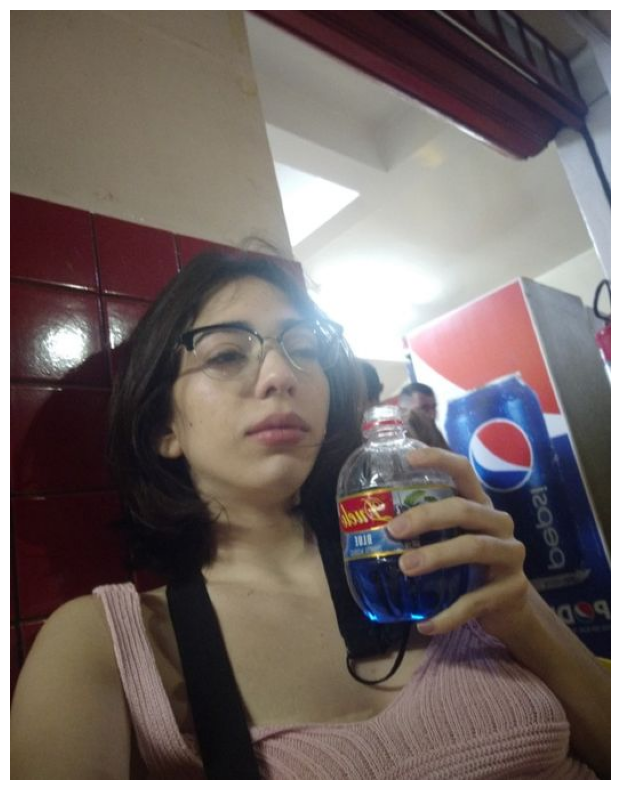

In [37]:
image = cv2.imread('/content/236958472_131198745862004_1031442335158270391_n.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

##Aplicando YOLO-NAS para detecção de objetos

[2023-05-21 02:10:48] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


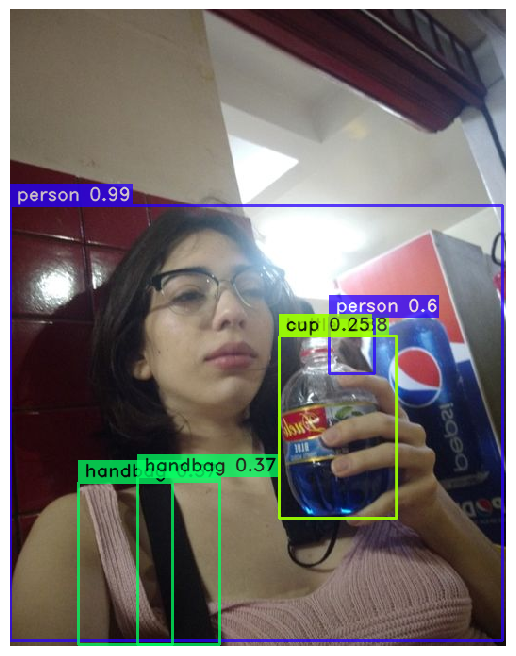

In [38]:
image_path = '/content/236958472_131198745862004_1031442335158270391_n.jpg'

model = models.get("yolo_nas_l", pretrained_weights="coco")
model.predict(image, conf=0.25).show()

conf_threshold = 0.25
detection_pred = model.predict(image_path, conf=conf_threshold)
detections = detection_pred.save('output_folder')

##Selecionando objetos com SAM

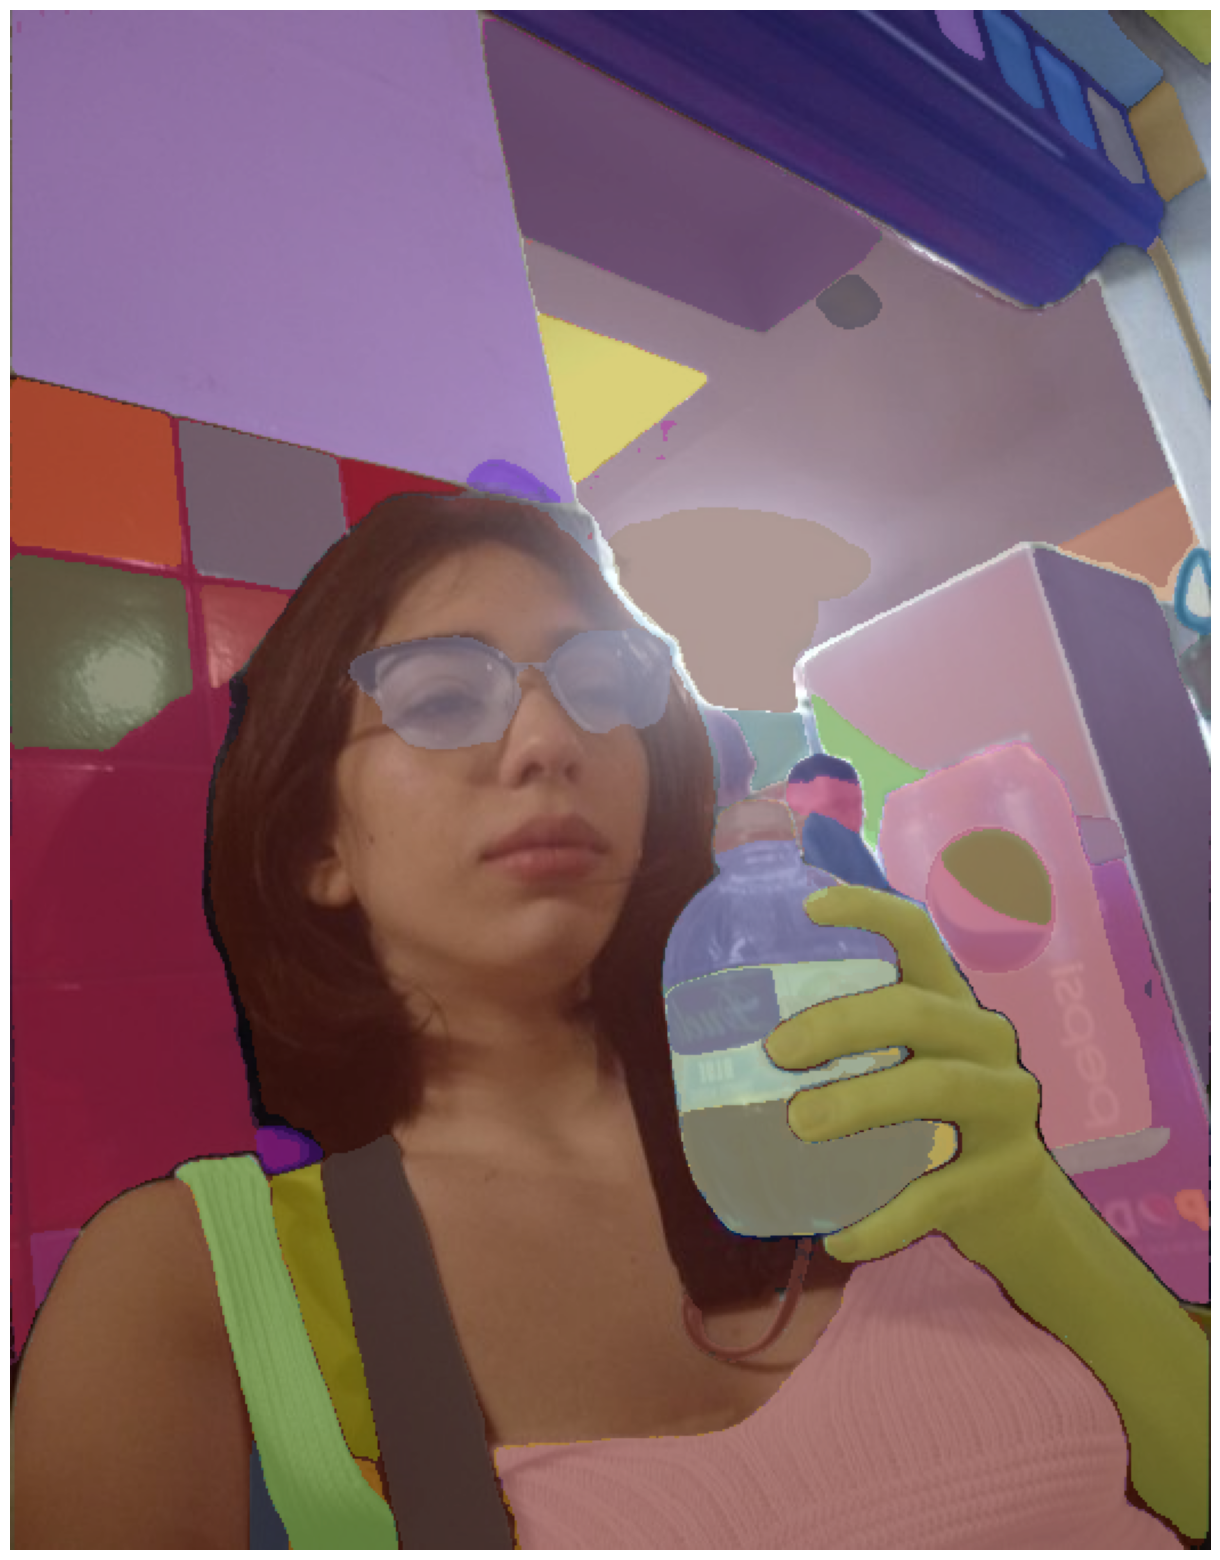

In [39]:
image = cv2.imread('/content/236958472_131198745862004_1031442335158270391_n.jpg')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
model_type = 'vit_h'
device = 'cuda'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

##Inferência com YOLO-NAS: Extraindo confiaça, labels e boouding boxes

In [40]:
image_path = '/content/236958472_131198745862004_1031442335158270391_n.jpg'

model = models.get("yolo_nas_l", pretrained_weights="coco")
conf_threshold = 0.25

detection_pred = model.predict(image_path, conf=conf_threshold)._images_prediction_lst
detection_pred = list(detection_pred)
detection_pred

[2023-05-21 02:11:45] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


[ImageDetectionPrediction(image=array([[[86, 73, 57],
         [88, 75, 59],
         [91, 78, 62],
         ...,
         [85, 80, 84],
         [85, 80, 84],
         [86, 81, 85]],
 
        [[87, 74, 58],
         [89, 76, 60],
         [91, 78, 62],
         ...,
         [84, 79, 83],
         [85, 80, 84],
         [85, 80, 84]],
 
        [[89, 76, 60],
         [91, 78, 62],
         [92, 79, 63],
         ...,
         [85, 80, 84],
         [85, 80, 84],
         [85, 80, 84]],
 
        ...,
 
        [[81, 65, 40],
         [81, 65, 40],
         [84, 68, 43],
         ...,
         [17, 13, 12],
         [20, 14, 14],
         [21, 15, 15]],
 
        [[82, 66, 41],
         [81, 65, 40],
         [84, 68, 43],
         ...,
         [17, 13, 12],
         [20, 14, 14],
         [21, 15, 15]],
 
        [[83, 67, 42],
         [82, 66, 41],
         [83, 67, 42],
         ...,
         [16, 12, 11],
         [20, 14, 14],
         [21, 15, 15]]], dtype=uint8), prediction=

##Extraindo apenas informações desejadas

In [41]:
bboxes_xyxy = detection_pred[0].prediction.bboxes_xyxy.tolist()
confidence = detection_pred[0].prediction.labels.tolist()
labels = detection_pred[0].prediction.labels.tolist()

print('Bouding Boxes (xyxy): ', bboxes_xyxy)
print('Confidence: ', confidence)
print('Labels: ', labels)

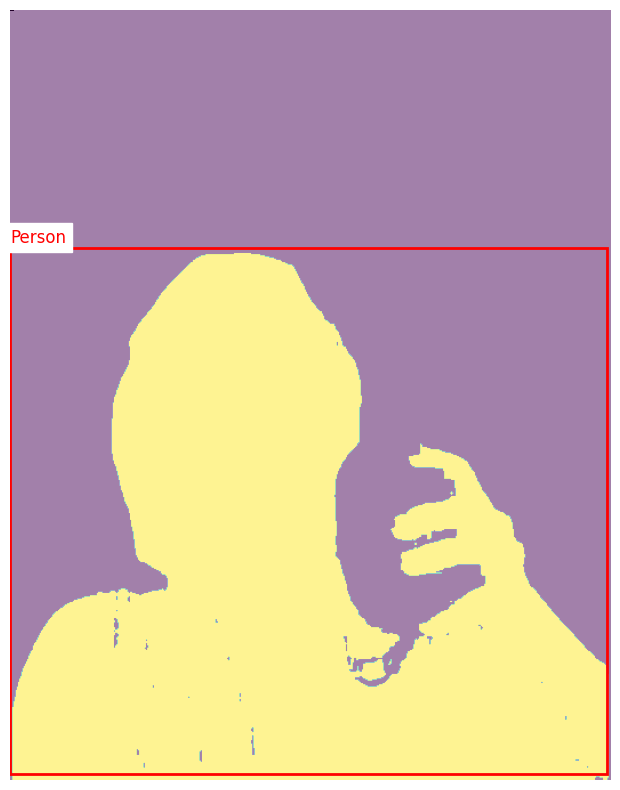

In [45]:
image_path = '/content/236958472_131198745862004_1031442335158270391_n.jpg'
image = cv2.imread(image_path)

sam_checkpoint = 'sam_vit_h_4b8939.pth'
model_type = 'vit_h'
device = 'cuda'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

image = image.transpose((2,0,1))
image = image / 255.0
image = np.expand_dims(image, axis=0)
image = np.float32(image)

input_box = np.array(bboxes_xyxy[0])

if labels[0] == 0:
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

if labels[0] == 0:
    plt.imshow(masks[0], alpha=0.5)
plt.gca().add_patch(plt.Rectangle((input_box[0], input_box[1]), input_box[2] - input_box[0], input_box[3] - input_box[1], linewidth=2, edgecolor='r', facecolor='none'))
plt.text(input_box[0], input_box[1] - 5, 'Person', fontsize=12, color='r', backgroundcolor='w')
plt.axis('off')
plt.savefig('resultado.png')
plt.show()